<a href="https://colab.research.google.com/github/AjmalSarwary/invest_ml/blob/master/code/MaxSharpeRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Finding the Max Shapre Ratio Portfolio


In [1]:
!git clone https://github.com/ajmalsarwary/invest_ml.git
%cd /content/invest_ml
import sys
sys.path.append('/content/invest_ml/code')

Cloning into 'invest_ml'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 112 (delta 26), reused 79 (delta 15), pack-reused 0
Receiving objects: 100% (112/112), 1.41 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/invest_ml


In [9]:
!git pull origin master
%cd /content/invest_ml
import sys
sys.path.append('/content/invest_ml/code')

remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 11 (delta 5), reused 11 (delta 5), pack-reused 0
Unpacking objects: 100% (11/11), 1.52 KiB | 389.00 KiB/s, done.
From https://github.com/ajmalsarwary/invest_ml
 * branch            master     -> FETCH_HEAD
   1b5aa52..3160872  master     -> origin/master
Updating 1b5aa52..3160872
Fast-forward
 code/invest_risk_kit.py | 59 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++--
 1 file changed, 57 insertions(+), 2 deletions(-)
/content/invest_ml


In [2]:
import invest_risk_kit as rk
import pandas as pd
import numpy as np

In [3]:
ind = rk.get_ind_returns()
er = rk.annualize_rets(ind["1996":"2000"],12)
cov = ind["1996":"2000"].cov()

In [4]:
def optimal_weights(n_points, er, cov):
  """
  -> list of weights to run the optimizer to minimize the vol
  """
  target_rs = np.linspace(er.min(), er.max(), n_points)
  weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
  return weights

def plot_ef(n_points, er, cov):
  """
  Plots the multi-asset efficient frontier
  """
  weights = optimal_weights(n_points, er, cov)
  rets = [rk.portfolio_return(w,er) for w in weights]
  vols = [rk.portfolio_vol(w,cov) for w in weights]
  ef = pd.DataFrame({
      "Returns": rets,
      "Volatility": vols
  })
  return ef.plot.line(x="Volatility", y="Returns", style='.-')

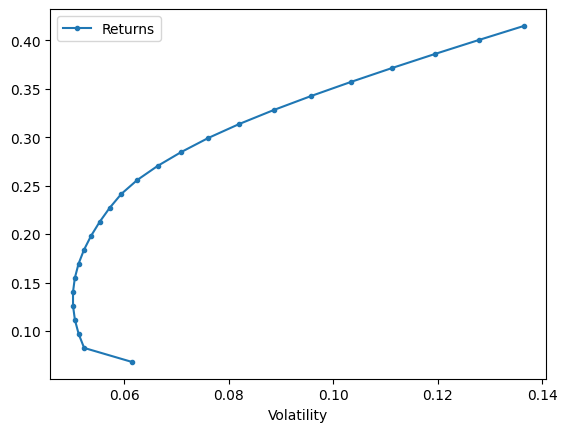

In [9]:
# Simulating allocation weights for 25 target retruns at min volatilities between
# min expected retrurns and max expected retruns
# for allocation of investment across 4 portfolios
l = ['Smoke', 'Fin', 'Games', 'Coal']
rk.plot_ef(25, er[l], cov.loc[l,l], False)

In [10]:
from scipy.optimize import minimize
def msr(riskfree_rate,er, cov):
    """
    Riskfree rate + ER + COV -> w

    """
    # number of portfolios
    n = er.shape[0]
    # initial allocation across portfolios
    init_guess = np.repeat(1/n, n)
    #constains:
    # n tuples trick to make n-tuples for the bounds of the allocations
    # bounds for each weight must be 0=< bound =<1
    bounds = ((0.0, 1.0),)*n


    # weights must sum to 1, i.e. 'sum(weights) -1 = 0
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }

    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
      """
      Returns the negative of the sharpe ratio
      """
      r = rk.portfolio_return(weights, er)
      vol = rk.portfolio_vol(weights, cov)
      return -(r - riskfree_rate)/vol


    # objective function: quadratic optimizer SLSQP
    results = minimize(neg_sharpe_ratio,
                       init_guess,
                       args=(riskfree_rate,er,cov,),
                       method="SLSQP",
                       options={'disp':False},
              constraints=(weights_sum_to_1),
                           bounds=bounds
    )
    # return only weights
    return results.x

<Axes: xlabel='Volatility'>

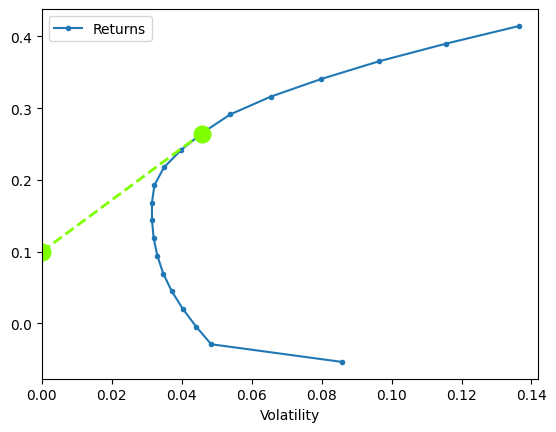

In [15]:
rk.plot_ef(20, er, cov, riskfree_rate=0.1)